In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [2]:
# Setting up categories for the different stars
cat = ['negative','neutral','positive']
def cat_y(y):
    if y<=2.0:
        return cat[0]
    elif y>=4.0:
        return cat[2]
    else:
        return cat[1]

In [3]:
# Following the same process as Bencina
def get_reviews(path, n_samples):
    dt = {}
    i=0
    with open(path) as f:
        for d in f.readlines():
            dt[i] = eval(d)
            i += 1
    df = pd.DataFrame.from_dict(dt, orient='index')[['reviewText','overall']]
    df = df[df['reviewText'].apply(lambda x: len(x.split())>=45)]
    df['bucket'] = df['overall'].apply(cat_y)
    
    df = df.groupby('bucket').apply(lambda x: x.sample(n=n_samples))
    return df

In [4]:
data = get_reviews('../data/reviews_Video_Games_5.json', 1000)
pd.set_option('display.max_colwidth', -1)
data.sample(3)

,,reviewText,overall,bucket
bucket,,,,
neutral,80432,"I was a big fan of the Ghost Recon games many years ago. This game is at best a slight evolution, really several years behind the curve. The graphics are decent, with bushes and leaves to try to conceal onself in. But there are no open fields or large hills and long distances or other nice terrain features that GR1 had. The maps here are ok, but there could be more.The single player mission is passable; but the AI has near perfect aim. Not at all like what terrorists in Mexico would likely have in a real battle with US SF troops.In multiplayer mode, most servers prohibit grenade launchers, which makes sense; but the soldier is only allowed one grenade. Worse, there is nothing else really in terms of tools or arms except the rifle, a worthless backup gun (except if you are a sniper you need your handgun sometimes), and a smoke grenade. There is otherwise nothing modern about this game - in fact it is more like WW1 with automatic rifles. No mines, sensors, overhead intelligence, communication.... you can type messages, but no automatic messages like in BF (by pressing the function keys, to say need reinforcement, enemy sighted, etc.). No indirect fire either. There is voice communication - if you pay (as far as I could figure out).This is a fun game, in part because it is a much more deliberate and paced than the BF games and other FPS. Only a few bullets kill, and there is no health to get. But other than some nicer graphics and a few effects, like cars blowing up if hit by grenades, there really is nothing new about this game compared to GR1 from 1999 or whatever.It's worth five or ten dollars, but not much more.",3.0,neutral
positive,69606,"So a lot of people are giving this game crap cuz it does not do anything ground breaking. Point accepted. But it is still loads of fun. The single player is quite challenging and the enemy AI is one of the best ive seen, although i cant say that for the allies as they keep dying and need to be revived. The online aspect is quite fast paced and the constantly changing objectives make for pretty intense gameplay. One issue i had online was with the auto aim, which i think is pretty cheap.On the flip side the control lag is something that needs adjusting to but i dont think tht itself justifies the 1 star rating ive seen a lot. I prefer the game without the control lag but its not a deal breaker when you look at all the other good things about the game. If you think it mite be a bother play the demo first and then think about it.",5.0,positive
neutral,31105,"As silly as it may sound to those reading a review of a Castlevania game, Castlevania: Harmony of Dissonance has got to be one of the weirdest games I have ever played. Point blank there are just SO many odd design choices within this game - some of them good, some of them pandering, some of them (surprising) game saving but NONE of them game breaking - that I'm dumbfounded that I like it and that it even works. Games with much more promise than Harmony have been forgotten for much less yet here's a game that is - dare i say it - actually ""fueled"" by its irreverent choices and memorable because of it.Now, you may be wondering what is just so ""weird"" about Harmony of Dissonance? Well, oddly enough the story begins with the soundtrack. I think most people that have partaken of what Konami offered here will agree the quality of the audio leaves a lot to be desired. Seriously, there are original GameBoy games that sound better - even those with lazy sound programming. For a game with the word ""Harmony"" in the title there isn't much to be heard musically, but this is just part of the stupid, logic-defying gamble that saves the game from itself. The game's audio prowess was sacrificed to make the game's world larger and it is the story line twist that explains the increased geography that ultimately makes the game worth playing. Yes, you heard that right, the twist explaining why the g

In [5]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(data['reviewText'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(data['reviewText'], use_idf=True, max_df=0.90, min_df=10)

In [6]:
n_topics = 10

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_topics=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

#lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

In [8]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
#show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model



In [9]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
mario, sonic, super, kart, level, nintendo, play, bros, like, new, parti, ds, veri, sega, just
Cluster #1:
stori, play, great, charact, graphic, rpg, like, good, just, level, time, gameplay, fun, end, final
Cluster #2:
like, time, just, play, level, charact, enemi, veri, realli, good, make, mission, stori, onli, way
Cluster #3:
wii, control, remot, use, play, motion, work, fun, just, version, like, nintendo, consol, wiimot, u
Cluster #4:
xbox, consol, ps, control, halo, microsoft, play, pc, use, version, just, buy, onli, like, great
Cluster #5:
play, like, fun, just, good, veri, graphic, time, great, control, realli, don't, better, buy, love
Cluster #6:
car, race, drive, play, like, racer, forza, track, just, wheel, time, fun, gt, graphic, nfs
Cluster #7:
sim, ea, play, download, buy, work, just, new, money, like, steam, instal, time, drm, review
Cluster #8:
player, play, mode, onlin, multiplay, like, fun, singl, campaign, j

In [10]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

#lda_c = lda_d.argmax(axis=1)

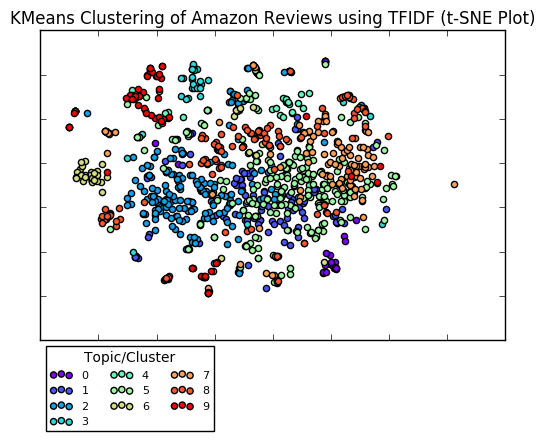

In [11]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

In [ ]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, data['bucket'], test_size=0.3)


In [13]:
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

Model accuracy predictions

LR model (negative rating): 70.1%
LR model (neutral rating): 65.0%
LR model (positive rating): 71.1%

NB model (negative rating): 67.0%
NB model (neutral rating): 64.0%
NB model (positive rating): 69.6%

SVM model (negative rating): 71.8%
SVM model (neutral rating): 63.7%
SVM model (positive rating): 74.9%

COMBINED model (negative rating): 70.1%
COMBINED model (neutral rating): 64.9%
COMBINED model (positive rating): 71.0%



In [14]:
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

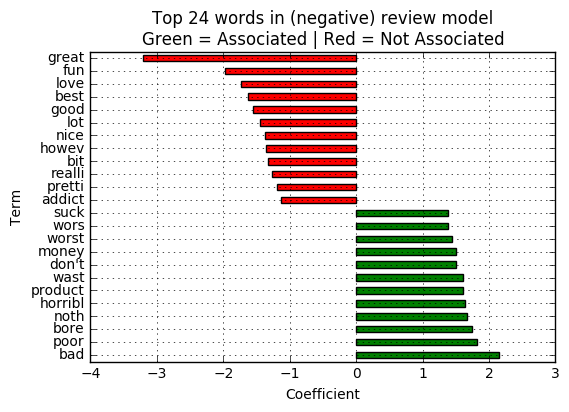

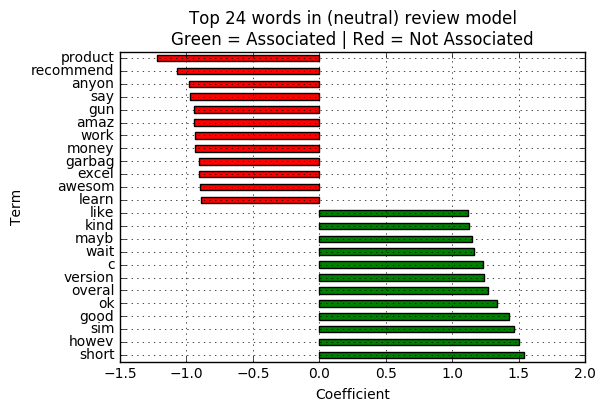

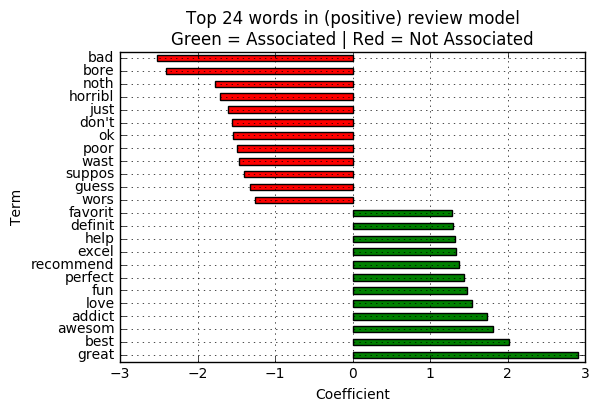

In [15]:
%matplotlib inline

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=cat[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)

In [16]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=lr_m[m].predict_proba(test_new)[0][1]))

In [17]:
test_review("This is the worst game I've played in my entire life. I really had high hopes for this game but every part of it has let me down. I really hope someone gets fired for creating this thing")

Review text: "This is the worst game I've played in my entire life. I really had high hopes for this game but every part of it has let me down. I really hope someone gets fired for creating this thing"

Model Predction
Model (negative): 42.9%
Model (neutral): 17.3%
Model (positive): 39.7%


In [18]:
test_review('This game is great')

Review text: "This game is great"

Model Predction
Model (negative): 2.5%
Model (neutral): 24.7%
Model (positive): 90.6%


In [19]:
test_review('This game is no adjectives it simply just is being the game that is existing as is.')

Review text: "This game is no adjectives it simply just is being the game that is existing as is."

Model Predction
Model (negative): 48.7%
Model (neutral): 25.1%
Model (positive): 24.1%


In [20]:
test_review('this is the game of games that gamey games should game like')

Review text: "this is the game of games that gamey games should game like"

Model Predction
Model (negative): 27.2%
Model (neutral): 49.9%
Model (positive): 22.7%
